# This Example shows how to classify EuroSAT satellite images using the deep learning model DeepSAT-V2.

Find the details of the DeepSAT-V2 model in the <a href="https://arxiv.org/abs/1911.07747">corresponding paper</a>

Find the details of the dataset <a href="https://github.com/phelber/EuroSAT">here</a>

### EuroSAT satellite dataset contains images from 10 different classes:

<ul>
<li>Annual Crop</li>
<li>Forest</li>
<li>Herbaceous Vegetation</li>
<li>Highway</li>
<li>Industrial</li>
<li>Pasture</li>
<li>Permanent Crop</li>
<li>Residential</li>
<li>River</li>
<li>SeaLake</li>
</ul>

### Import Modules

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from geotorchai.models.raster import DeepSatV2
from geotorchai.datasets.raster import EuroSAT
from geotorchai.utility import TorchAdapter

# Import Apache Sedona
from sedona.spark import *

## Import PySpark
from pyspark.sql import SparkSession

## Import distributed modules
from torch.utils.data import DistributedSampler, DataLoader
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from pyspark.ml.torch.distributor import TorchDistributor

import warnings
# Ignore FutureWarning warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
config = SedonaContext.builder().master(MASTER_URL).config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.4_2.12:1.4.1,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2').getOrCreate()

sedona = SedonaContext.create(config)
sc = sedona.sparkContext

23/08/11 19:05:56 WARN Utils: Your hostname, Kanchans-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.1.6 instead (on interface en0)
23/08/11 19:05:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/kanchan/.ivy2/cache
The jars for the packages stored in: /Users/kanchan/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-3.4_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-939910f5-888b-434f-9413-cf06a84f1e60;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/kanchan/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 in central
	found org.datasyslab#geotools-wrapper;1.4.0-28.2 in central
:: resolution report :: resolve 87ms :: artifacts dl 3ms
	:: modules in use:
	org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 from central in [default]
	org.datasyslab#geotools-wrapper;1.4.0-28.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-939910f5-888b-434f-9413-cf06a84f1e60
	confs: [default]
	0 artifacts copied, 2 already retrieved (0kB/2ms)
23/08/11 19:05:56 WARN NativeCodeLoader: Unable to load

## Get Path Prefix

In [3]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else ''

print(PATH_PREFIX)

In [4]:
## Define parameters
learning_rate = 0.0002
batch_size = 16
epoch_nums = 5

## make sure that PATH_TO_DATASET exists in the running directory
PATH_TO_DATASET = PATH_PREFIX + "data/eurosat"

### Load Data and Add Normalization Transformation

In [5]:
## load data and calculate mean and std to perform normalization transform
## Set download=True if dataset is not available in the given path
full_data = EuroSAT(root = PATH_TO_DATASET, download=False)

full_loader = DataLoader(full_data, batch_size= batch_size)
channels_sum, channels_squared_sum, num_batches = 0, 0, 0
for i, sample in enumerate(full_loader):
    data_temp, _ = sample
    channels_sum += torch.mean(data_temp, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data_temp**2, dim=[0, 2, 3])
    num_batches += 1

mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

In [6]:
## Define the transform operation
sat_transform = transforms.Normalize(mean, std)
## Load data with desired transformation and additional handcrafted features enabled
full_data = EuroSAT(root = PATH_TO_DATASET, include_additional_features = True, transform = sat_transform)

### Get All Class Names and Corresponding Labels

In [7]:
## find all class names and corresponding labels
print(full_data.get_class_labels())

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Display Spectral Bands of the First Image

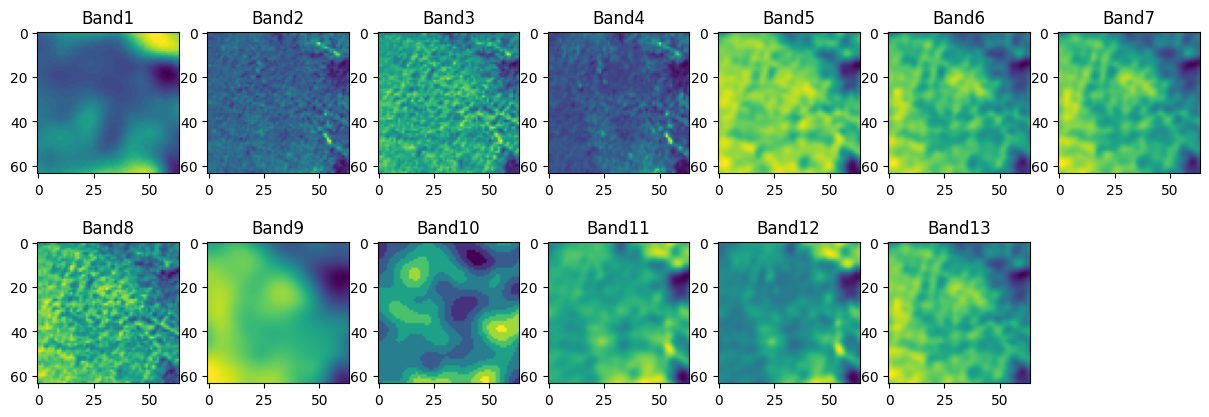

In [ ]:
## Display various bands from an input image
input_data, label, features = full_data[0]
TorchAdapter.visualize_all_bands(input_data, 13, 2, 7)

### Method to Return Model

In [9]:
def get_model():
    ## Define Model
    model = DeepSatV2(13, 64, 64, 10, len(full_data.ADDITIONAL_FEATURES))
    return model

### Train Model
Accuracy will not be high sinvce training is performed on a small dataset for only 5 epochs

In [10]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    for i, sample in enumerate(train_loader):
        inputs, labels, features = sample
        inputs = inputs.to(device)
        features = features.type(torch.FloatTensor).to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(True):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, features)
            loss = loss_fn(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
    return loss.item()

In [11]:
def train_model(model, loader, device):
    ## Define hyper-parameters
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for e in range(epoch_nums):
        epoch_loss = train_one_epoch(model, loader, optimizer, loss_fn, device)
        print('Epoch [{}/{}], Training Loss: {:.4f}'.format(e + 1, epoch_nums, epoch_loss))

In [12]:
def train_distributed(use_gpu):
    backend = "nccl" if use_gpu else "gloo"
    dist.init_process_group(backend)
    device = int(os.environ["LOCAL_RANK"]) if use_gpu  else "cpu"
    model = get_model().to(device)
    model_ddp = DDP(model)
    sampler = DistributedSampler(full_data)
    loader = DataLoader(full_data, batch_size=batch_size, sampler=sampler)

    train_model(model_ddp, loader, device)

## Start Distributed Training

In [ ]:
print("Starting training")
distributor = TorchDistributor(num_processes=2, local_mode=True, use_gpu=False)
distributor.run(train_distributed, False)